In [63]:
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [64]:
load_dotenv()

True

In [65]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [85]:
@tool
def stockprice(symbol : str) -> float:
    """Return the current price of the stock given the stock symbol
    :param symbol : stock symbol
    return : corrent price of the stock"""
    return {
        "MSFT" : 400.0,
        "AAPL" : 500.0,
        "RIL" : 350.32
    }.get(symbol, 0.0)

tools = [stockprice]

In [86]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [87]:
def chatbot(state : State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [88]:
builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
# builder.add_edge("chatbot_node", END)

graph = builder.compile()

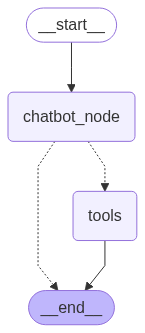

In [89]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [90]:
response = graph.invoke({"messages": [{"role": "user", "content": "what is the price of MSFT stock price."}]})
response["messages"][-1].content

'400.0'